# 0. Importación de librerías

In [1]:
# Los datos empleados como input se deben ubicar en la ruta "./input/" dentro del directorio en el que se ubique este entorno
import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# Configuración del entorno
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import os
import re # Para las expresiones regulares, hacemos uso de algoritmos de Natural Language Processing (NLP)

from nltk.stem.snowball import SnowballStemmer # Para la simplificación del texto (NLP)
import nltk
from nltk.corpus import stopwords # importamos el corpus de palabras que no aportan valor 
nltk.download("stopwords")

#Librerías de sklearn para ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#Librería para el Parseo del cuerpo del email
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Polex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Lectura de datos y generación del Dataframe

In [32]:
# Generamos el Dataframe a partir de los datos de input
#df = pd.read_csv("C:/Users/Polex/ML/TFM/input/spam_ham_dataset.csv") # Se deberá sustituir esta ruta por la ubicación del dataset en nuestro sistema
df = pd.read_csv("./input/spam_ham_dataset.csv")
df #Imprimimos unas muestras del Dataframe

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [33]:
# Eliminamos la columna "Unnamed" y renombramos el resto de columnas (encabezado)
df.drop('Unnamed: 0', axis=1, inplace = True) 
df.columns = ['label', 'text', 'class'] 
df

,label,text,class
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,ham,Subject: industrial worksheets for august 2000...,0


In [34]:
# Imprimimos la tupla para representar las dimensiones del DataFrame
df.shape

(5171, 3)

In [35]:
# Imprimimos la información del DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5171 non-null   object
 1   text    5171 non-null   object
 2   class   5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 80.9+ KB


[Para nuestro modelo no haremos uso de la variable label, dado que emplearemos class para comprobar el resultado de las predicciones]
Columnas:
- 'label': Variable objetivo a predecir (en formato de cadena de texto o string) --> toma los siguientes valores: "ham" o "spam"
- 'text': Asunto del email y contenidos
- 'class': Variable objetivo a predecir (en formato de número entero o integer) --> toma valores entre: 0(=ham) or 1(=spam)

<AxesSubplot:xlabel='class', ylabel='count'>

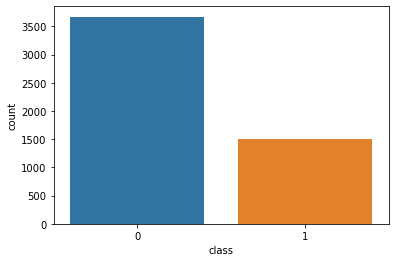

In [36]:
# Mostramos el conteo de la categorización de muestras (benignas=ham o spam) mediante un diagrama de barras
import seaborn as sns
sns.countplot(x=df['class'])

In [37]:
# Mostramos un conteo de los datos, diferenciando entre muestras benignas (0) y muestras de maliciosas o de spam (1)
pd.Series(df['class']).value_counts()

0    3672
1    1499
Name: class, dtype: int64

In [38]:
# Comprobamos que el conteo de nulos en ambas columnas sea 0
df.isna().sum()

label    0
text     0
class    0
dtype: int64

# 2. Preprocesamiento de los datos

In [39]:
# Función que encapsula el código para el preprocesamiento del contenido de los emails
def word_salad(body):
    '''Produce a word salad from email body.'''    
    # Parseo del código HTML para extraer el texto
    soup = BeautifulSoup(body, 'html.parser')
    
    # Se extrae el texto del email
    body = soup.get_text()

    # Se realiza el conteo de los elementos HTML y de los enlaces
    nhtml = len(soup.find_all())
    nlinks = len(soup.find_all("a"))
    body = body + nhtml*" htmltag " + nlinks*" linktag "
    
    # Se convierte todo el texto a minúsculas
    body = body.lower()
    
    # Se reemplazan las URLs por cadenas de texto especiales
    regx = re.compile(r"(http|https)://[^\s]*")
    body, nhttps = regx.subn(repl=" httpaddr ", string=body)

    # Se reemplazan las direcciones de email por cadenas de texto especiales
    regx = re.compile(r"\b[^\s]+@[^\s]+[.][^\s]+\b")
    body, nemails = regx.subn(repl=" emailaddr ", string=body)
    
    # Se reemplazan los números por cadenas de texto especiales
    regx = re.compile(r"\b[\d.]+\b")
    body = regx.sub(repl=" number ", string=body)

    # Se reemplazan los símbolos '$' , '!' y '?' por cadenas de texto especiales
    regx = re.compile(r"[$]")
    body = regx.sub(repl=" dollar ", string=body)
    regx = re.compile(r"[!]")
    body = regx.sub(repl=" exclammark ", string=body)
    regx = re.compile(r"[?]")
    body = regx.sub(repl=" questmark ", string=body)

    # Se eliminan los símbolos de puntuación (reemplazandolos por espacios en blanco)
    regx = re.compile(r"([^\w\s]+)|([_-]+)")  
    body = regx.sub(repl=" ", string=body)
    
    # Se reemplazan los saltos de línea y lineas en blanco por cadenas de texto especiales
    regx = re.compile(r"\n")
    body = regx.sub(repl=" newline ", string=body)
    regx = re.compile(r"\n\n")
    body = regx.sub(repl=" blankline ", string=body)

    # Se combinan los espacios en blanco seguidos en uno
    regx = re.compile(r"\s+")
    body = regx.sub(repl=" ", string=body)

    # Se eliminan los espacios en blanco iniciales o finales
    body = body.strip(" ")
 
    # Se eliminan las palabras que no aportan valor (llamadas 'stopwords')
    bodywords = body.split(" ")
    keepwords = [word for word in bodywords if word not in stopwords.words('english')]

    # Simplificamos las palabras en cuanto a su léxico
    stemmer = SnowballStemmer("english")
    stemwords = [stemmer.stem(wd) for wd in keepwords]
    body = " ".join(stemwords)
    
    return body

### Proceso de simplificación de las palabras en cuanto a su léxico

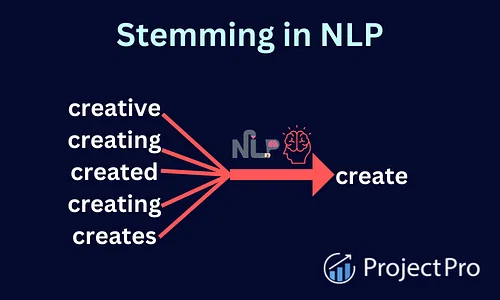

https://www.projectpro.io/article/stemming-in-nlp/780

In [40]:
#Ejemplo
body = df['text'].iloc[0]
processed = word_salad(body)
processed

'subject enron methanol meter number newlin follow note gave monday number number number preliminari newlin flow data provid daren newlin pleas overrid pop daili volum present zero reflect daili newlin activ obtain gas control newlin chang need asap econom purpos'

## 2.1. Generamos nuestro Corpus de Emails

In [41]:
emails_processed =  ["email_processed"]*len(df)  # Hacemos una reserva de la memoria, para hacer  append

for index, row in df.iterrows():
    
    body = df['text'].iloc[index] # Extraemos tan solo el texto del cuerpo del email
    processed = word_salad(body)  # Función de preprocesado
    emails_processed[index] = processed

In [42]:
# Se incluyen los emails preprocesados
df_processed = df
df_processed['email_processed'] = emails_processed

In [43]:
df_processed

,label,text,class,email_processed
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,subject enron methanol meter number newlin fol...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,subject hpl nom januari number number newlin s...
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,subject neon retreat newlin ho ho ho around wo...
3,spam,"Subject: photoshop , windows , office . cheap ...",1,subject photoshop window offic cheap main tren...
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,subject indian spring newlin deal book teco pv...
...,...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0,subject put number ft newlin transport volum d...
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0,subject number number number follow nom newlin...
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0,subject calpin daili gas nomin newlin newlin n...
5169,ham,Subject: industrial worksheets for august 2000...,0,subject industri worksheet august number activ...


0    3672
1    1499
Name: class, dtype: int64

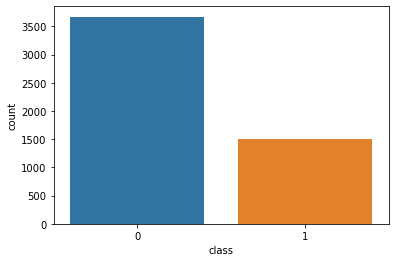

In [44]:
# Comprobamos que tras la transformación del texto el target se sigue manteniendo con el mismo volumen
import seaborn as sns
sns.countplot(x=df_processed['class'])
pd.Series(df_processed['class']).value_counts()

## 2.2 Separación entre datos de entrenamiento y datos de validación 

In [45]:
# Separamos el texto a analizar (Features) del resultado (Target)
df_X = pd.DataFrame(df_processed, columns=['email_processed'])  # Features
df_y = pd.DataFrame(df_processed, columns=['class']) # Target  (1 = spam (malicioso) // 0 = ham (benigno))

X = df_X.loc[:, 'email_processed'] # Features
y = df_y.loc[:, 'class'] # Target  (1 = spam (malicioso) // 0 = ham (benigno))

# Comprobamos que el tamaño de los arrays no ha variado
print(f"Shape of X: {X.shape}\nshape of y: {y.shape}")

Shape of X: (5171,)
shape of y: (5171,)


In [46]:
#Imprimimos una muestra del texto a analizar (Feature) de los emails
X

0       subject enron methanol meter number newlin fol...
1       subject hpl nom januari number number newlin s...
2       subject neon retreat newlin ho ho ho around wo...
3       subject photoshop window offic cheap main tren...
4       subject indian spring newlin deal book teco pv...
                              ...                        
5166    subject put number ft newlin transport volum d...
5167    subject number number number follow nom newlin...
5168    subject calpin daili gas nomin newlin newlin n...
5169    subject industri worksheet august number activ...
5170    subject import onlin bank alert newlin dear va...
Name: email_processed, Length: 5171, dtype: object

In [47]:
#Imprimimos una muestra del los resultados (Target)
y

0       0
1       0
2       0
3       1
4       0
       ..
5166    0
5167    0
5168    0
5169    0
5170    1
Name: class, Length: 5171, dtype: int64

In [48]:
# Dividimos las muestras del Dataframe original para obtener 2 conjuntos de datos: 
#  80% Datos de entrenamiento para alimentar el algoritmo.
#  20% Test
# X_train: Variable con el texto de las muestras a emplear para el entrenamiento
# y_train: Variable con los resultados correspondientes a las muestras de entrenamiento, empleado para valorar el resultado del entrenamiento
# X_test: Variable con el texto de las muestras a emplear para la validación del modelo
# y_test Variable con los resultados correspondientes a las muestras usadas para la validación del modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
y_train.value_counts()

0    2930
1    1206
Name: class, dtype: int64

In [50]:
y_test.value_counts()

0    742
1    293
Name: class, dtype: int64

# 3. Preprocesado del texto para los modelos de ML

### Mapeado del Texto en Vectores

###  1 Palabra (vectorizer)

In [51]:
# Empleamos la función de vectorización para generar una lista de vocabulario
vectorizer = CountVectorizer(min_df=0.03, max_df=1.0)  
vectorizer.fit(X_train)

CountVectorizer(min_df=0.03)

In [52]:
print('Nº. de Tokens: ',len(vectorizer.get_feature_names_out()))

Nº. de Tokens:  338


In [53]:
vectorizer.get_feature_names_out()[10:17]

array(['agreement', 'alloc', 'alreadi', 'also', 'america', 'ami', 'anoth'],
      dtype=object)

In [54]:
#Preparamos los datos de entrenamiento
dtv_train = vectorizer.transform(X_train)

In [55]:
# Imprimimos un ejemplo del conteo de palabras realizado
dtv_train[0].toarray()

array([[ 0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  3,  0,  0,  2,  0,  0,  0,  0,  2,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  1,  0,  0,  0,  1,  1,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  1,  0,  0, 15,  2,  0,
         0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0, 

In [56]:
dtv_test = vectorizer.transform(X_test)

In [57]:
## Exportamos los datos preprocesados a un fichero CSV para futuras iteraciones del modelo##

# Convertimos la matriz de dispersión en una matriz de densidad
dense_matrix_train = dtv_train.todense()
dense_matrix_test = dtv_test.todense()

# Generamos un nuevo DataFrame a partir de la matriz de densidad
df_train = pd.DataFrame(dense_matrix_train, columns=vectorizer.get_feature_names_out())
df_test = pd.DataFrame(dense_matrix_test, columns=vectorizer.get_feature_names_out())

# Incluimos el Target
df_train['target'] = y_train.values
df_test['target'] = y_test.values

# Combinamos los DataFrames de Entrenamiento (train) y Evaluación (test)
df_dataset = pd.concat([df_train, df_test])

# Exportamos el CSV
df_dataset.to_csv('dataset_vector_spam_ham.csv')

### 1 a 2 Palabras (vectorizer_ngram)

In [58]:
# Empleamos la función de vectorización para generar una lista de vocabulario
vectorizer_ngram = CountVectorizer(min_df=0.03, max_df=1.0, ngram_range=(1, 2)) 
vectorizer_ngram.fit(X_train)

CountVectorizer(min_df=0.03, ngram_range=(1, 2))

In [59]:
print('No.of Tokens: ',len(vectorizer_ngram.get_feature_names_out()))

No.of Tokens:  480


In [60]:
vectorizer_ngram.get_feature_names_out()[150:158]

array(['fw', 'fyi', 'fyi newlin', 'gari', 'gas', 'gas daili',
       'gas newlin', 'gather'], dtype=object)

In [61]:
#Preparamos los datos de entrenamiento
dtv_train_ngram = vectorizer_ngram.transform(X_train)
# Imprimimos un ejemplo
dtv_train_ngram[0].toarray()

array([[ 0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  3,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,
         2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  1,  1,  1,  0,
         0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

In [62]:
dtv_test_ngram = vectorizer_ngram.transform(X_test)

In [63]:
## Exportamos los datos preprocesados a un fichero CSV para futuras iteraciones del modelo##

# Convertimos la matriz de dispersión en una matriz de densidad
dense_matrix_train = dtv_train_ngram.todense()
dense_matrix_test = dtv_test_ngram.todense()

# Generamos un nuevo DataFrame a partir de la matriz de densidad
df_train = pd.DataFrame(dense_matrix_train, columns=vectorizer_ngram.get_feature_names_out())
df_test = pd.DataFrame(dense_matrix_test, columns=vectorizer_ngram.get_feature_names_out())

# Incluimos el Target
df_train['target'] = y_train.values
df_test['target'] = y_test.values

# Combinamos los DataFrames de Entrenamiento (train) y Evaluación (test)
df_dataset = pd.concat([df_train, df_test])

# Exportamos el CSV
df_dataset.to_csv('dataset_vector_ngram_spam_ham.csv')

# 4. Entrenamiento del Modelo

In [64]:
# Algoritmo de entrenamiento 1: Haciendo uso del solver 'LibLinear' (algoritmo de descenso de coordenadas)
from sklearn.linear_model import LogisticRegression

clf_liblinear = LogisticRegression(solver='liblinear', max_iter=445, random_state=42) 

clf_liblinear.fit(dtv_train, y_train)

# Predicción de la clase (da como resultado spam o no spam, la que mayor probabilidad tenga)
y_pred_liblinear = clf_liblinear.predict(dtv_test) 

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_liblinear, digits=4))

              precision    recall  f1-score   support

           0     0.9794    0.9596    0.9694       742
           1     0.9026    0.9488    0.9251       293

    accuracy                         0.9565      1035
   macro avg     0.9410    0.9542    0.9472      1035
weighted avg     0.9576    0.9565    0.9568      1035



In [65]:
# Algoritmo de entrenamiento - 2: Haciendo uso del solver 'lbfgs' (Algoritmo Broyden-Fletcher-Goldfarb-Shanno de memoria limitada)
from sklearn.linear_model import LogisticRegression

clf_lbfgs = LogisticRegression(solver='lbfgs', max_iter=445, random_state=42)

clf_lbfgs.fit(dtv_train, y_train)

# Predicción de la clase (da como resultado spam o no spam, la que mayor probabilidad tenga)
y_pred_lbfgs = clf_lbfgs.predict(dtv_test) 

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lbfgs, digits=4))

              precision    recall  f1-score   support

           0     0.9807    0.9596    0.9700       742
           1     0.9029    0.9522    0.9269       293

    accuracy                         0.9575      1035
   macro avg     0.9418    0.9559    0.9485      1035
weighted avg     0.9587    0.9575    0.9578      1035



In [66]:
# Algoritmo de entrenamiento 3: Haciendo uso del solver 'LibLinear' (algoritmo de descenso de coordenadas)
# Vectorizacion de 1 a 2 palabras (vectorizer_ngram)
from sklearn.linear_model import LogisticRegression

clf_liblinear_ngram = LogisticRegression(solver='liblinear', max_iter=445, random_state=42) 

clf_liblinear_ngram.fit(dtv_train_ngram, y_train)

y_pred_liblinear_ngram = clf_liblinear_ngram.predict(dtv_test_ngram) # Predicción de la clase (da como resultado spam o no spam, la que mayor probabilidad tenga)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_liblinear_ngram, digits=4))

              precision    recall  f1-score   support

           0     0.9835    0.9650    0.9741       742
           1     0.9153    0.9590    0.9367       293

    accuracy                         0.9633      1035
   macro avg     0.9494    0.9620    0.9554      1035
weighted avg     0.9642    0.9633    0.9635      1035



In [67]:
# Algoritmo de entrenamiento - 4: Haciendo uso del solver 'lbfgs' (Algoritmo Broyden-Fletcher-Goldfarb-Shanno de memoria limitada)
# Vectorizacion de 1 a 2 palabras (vectorizer_ngram)
from sklearn.linear_model import LogisticRegression

clf_lbfgs_ngram = LogisticRegression(solver='lbfgs', max_iter=445, random_state=42)

clf_lbfgs_ngram.fit(dtv_train_ngram, y_train)

y_pred_lbfgs_ngram = clf_lbfgs_ngram.predict(dtv_test_ngram) # Predicción de la clase (da como resultado spam o no spam, la que mayor probabilidad tenga)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lbfgs_ngram, digits=4))

              precision    recall  f1-score   support

           0     0.9835    0.9650    0.9741       742
           1     0.9153    0.9590    0.9367       293

    accuracy                         0.9633      1035
   macro avg     0.9494    0.9620    0.9554      1035
weighted avg     0.9642    0.9633    0.9635      1035



# 5. Validacion del Modelo

## 5.1 Validación del modelo 1 (empleando 'LibLinear')

In [68]:
# Importación de la librería de métricas (metrics)
from sklearn import metrics

cnf_matrix_liblinear = metrics.confusion_matrix(y_test, y_pred_liblinear)
cnf_matrix_liblinear

array([[712,  30],
       [ 15, 278]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

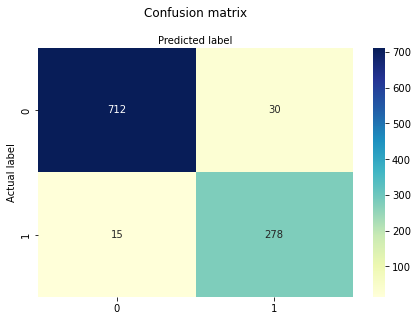

In [69]:
# Importación de los modulos necesarios
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Generación del mapa de calor
sns.heatmap(pd.DataFrame(cnf_matrix_liblinear), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Validación mediante curva AUC // ROC CURVE

In [70]:
prob_liblinear = clf_liblinear.predict_proba(dtv_test) # # Probabilidad de cada clase (probabilidad de spam y no spam)
# Seleccionamos unicamente la columna que indica que es spam, que serán los 1
prob_liblinear = prob_liblinear[:,1]

0.986888586331564


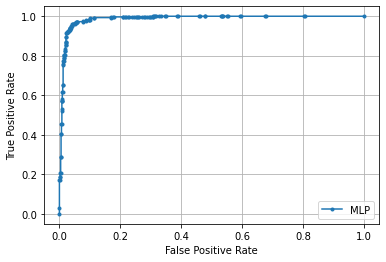

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc_liblinear = roc_auc_score(y_test, prob_liblinear)
print(auc_liblinear)

fpr, tpr, thresholds = roc_curve(y_test, prob_liblinear)

plt.plot(fpr, tpr, marker='.', label='MLP')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [72]:
# Importancia de las Feature para la predicción de Spam
bound_min_importance_word = len(vectorizer.get_feature_names_out())-15
bound_max_importance_word = len(vectorizer.get_feature_names_out())
len(vectorizer.get_feature_names_out())

338

<AxesSubplot:ylabel='Feature'>

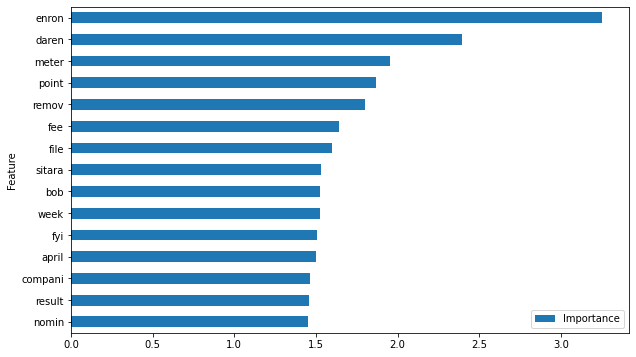

In [73]:
# Cálculo de coeficientes
coefficients_liblinear = clf_liblinear.coef_

avg_importance_liblinear = np.mean(np.abs(coefficients_liblinear), axis=0)
feature_importance_liblinear = pd.DataFrame({'Feature': vectorizer.get_feature_names_out(), 'Importance': avg_importance_liblinear})
feature_importance_liblinear = feature_importance_liblinear.sort_values('Importance', ascending=True)
feature_importance_liblinear[bound_min_importance_word:bound_max_importance_word].plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [74]:
# Mostramos una matriz en la cual se puede observar la 'importancia' que se le ha dado a cada palabra en el proceso de predicción
pd.set_option('display.max_rows', bound_max_importance_word)
feature_importance_liblinear

,Feature,Importance
186,need,0.002842
203,oper,0.002861
135,import,0.008044
255,said,0.008126
40,clyne,0.010540
42,come,0.011741
288,sure,0.012490
205,origin,0.012741
121,great,0.014216
197,number,0.015034


## 5.2 Validación del modelo 2 (empleando 'lbfgs')

In [75]:
# import the metrics class
from sklearn import metrics

cnf_matrix_lbfgs = metrics.confusion_matrix(y_test, y_pred_lbfgs)
cnf_matrix_lbfgs

array([[712,  30],
       [ 14, 279]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

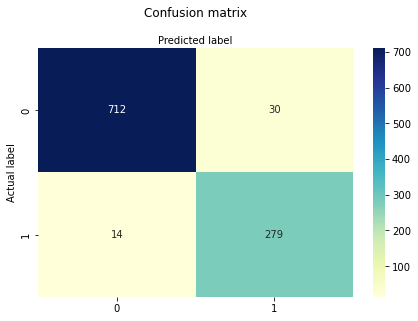

In [76]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_lbfgs), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Validación mediante curva AUC // ROC CURVE

In [77]:
prob_lbfgs = clf_lbfgs.predict_proba(dtv_test) # # Probabilidad de cada clase (probabilidad de spam y no spam)
# Seleccionamos unicamente la columna que indica que es spam, que serán los 1
prob_lbfgs = prob_lbfgs[:,1]

0.9870219773143336


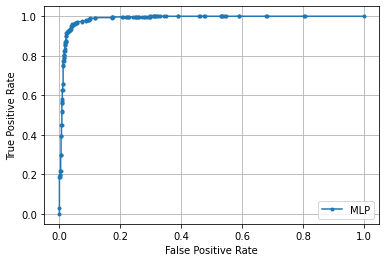

In [78]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc_lbfgs = roc_auc_score(y_test, prob_lbfgs)
print(auc_lbfgs)

fpr, tpr, thresholds = roc_curve(y_test, prob_lbfgs)

plt.plot(fpr, tpr, marker='.', label='MLP')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [79]:
# Importancia de las Feature para la predicción de Spam
bound_min_importance_word = len(vectorizer.get_feature_names_out())-15
bound_max_importance_word = len(vectorizer.get_feature_names_out())
len(vectorizer.get_feature_names_out())

338

<AxesSubplot:ylabel='Feature'>

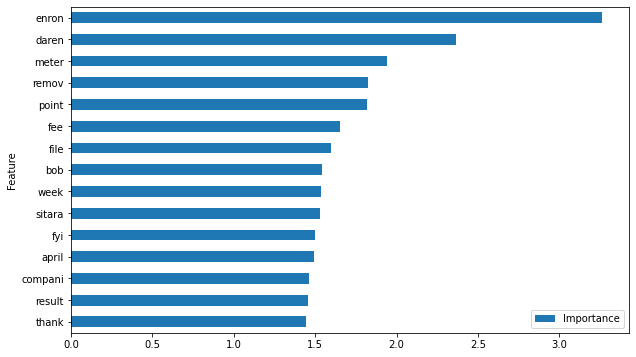

In [80]:
# Cálculo de coeficientes
coefficients_lbfgs = clf_lbfgs.coef_

avg_importance_lbfgs = np.mean(np.abs(coefficients_lbfgs), axis=0)
feature_importance_lbfgs = pd.DataFrame({'Feature': vectorizer.get_feature_names_out(), 'Importance': avg_importance_lbfgs})
feature_importance_lbfgs = feature_importance_lbfgs.sort_values('Importance', ascending=True)
feature_importance_lbfgs[bound_min_importance_word:bound_max_importance_word].plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [81]:
# Mostramos una matriz en la cual se puede observar la 'importancia' que se le ha dado a cada palabra en el proceso de predicción
pd.set_option('display.max_rows', bound_max_importance_word)
feature_importance_lbfgs

,Feature,Importance
203,oper,0.008736
186,need,0.009981
40,clyne,0.010680
157,link,0.011069
255,said,0.011481
234,put,0.012253
197,number,0.015978
236,questmark,0.016574
107,free,0.018488
135,import,0.021603


## 5.3 Validación del modelo 3 (empleando 'LibLinear' y vectorizer_ngram)

In [82]:
# Importación de la librería de métricas (metrics)
from sklearn import metrics

cnf_matrix_liblinear_ngram = metrics.confusion_matrix(y_test, y_pred_liblinear_ngram)
cnf_matrix_liblinear_ngram

array([[716,  26],
       [ 12, 281]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

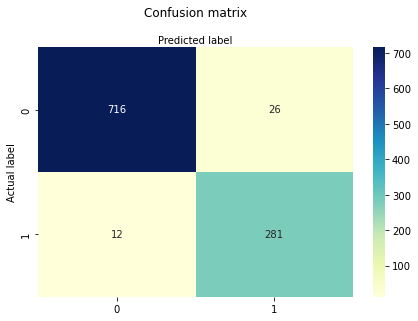

In [83]:
# Importación de los modulos necesarios
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Generación del mapa de calor
sns.heatmap(pd.DataFrame(cnf_matrix_liblinear_ngram), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Validación mediante curva AUC // ROC CURVE

In [84]:
prob_liblinear_ngram = clf_liblinear_ngram.predict_proba(dtv_test_ngram) # # Probabilidad de cada clase (probabilidad de spam y no spam)
# Seleccionamos unicamente la columna que indica que es spam, que serán los 1
prob_liblinear_ngram = prob_liblinear_ngram[:,1]

0.9873577546157879


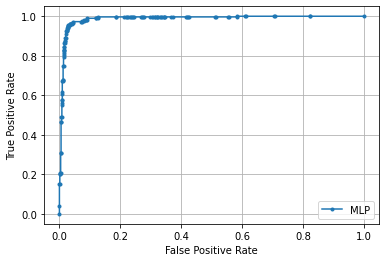

In [85]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc_liblinear_ngram = roc_auc_score(y_test, prob_liblinear_ngram)
print(auc_liblinear_ngram)

fpr, tpr, thresholds = roc_curve(y_test, prob_liblinear_ngram)

plt.plot(fpr, tpr, marker='.', label='MLP')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [86]:
# Importancia de las Feature para la predicción de Spam
bound_min_importance_word = len(vectorizer_ngram.get_feature_names_out())-15
bound_max_importance_word = len(vectorizer_ngram.get_feature_names_out())
len(vectorizer_ngram.get_feature_names_out())

480

<AxesSubplot:ylabel='Feature'>

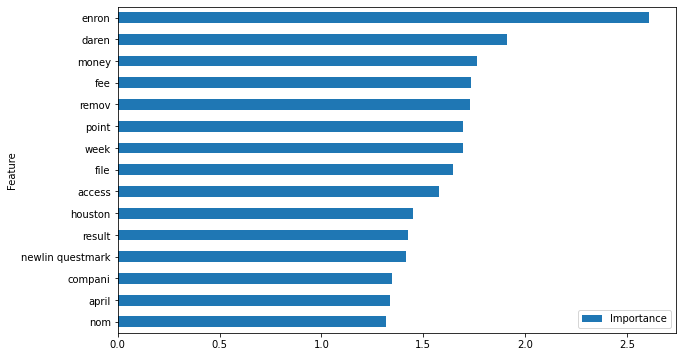

In [87]:
# Cálculo de coeficientes
coefficients_liblinear_ngram = clf_liblinear_ngram.coef_

avg_importance_liblinear_ngram = np.mean(np.abs(coefficients_liblinear_ngram), axis=0)
feature_importance_liblinear_ngram = pd.DataFrame({'Feature': vectorizer_ngram.get_feature_names_out(), 'Importance': avg_importance_liblinear_ngram})
feature_importance_liblinear_ngram = feature_importance_liblinear_ngram.sort_values('Importance', ascending=True)
feature_importance_liblinear_ngram[bound_min_importance_word:bound_max_importance_word].plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [88]:
# Mostramos una matriz en la cual se puede observar la 'importancia' que se le ha dado a cada palabra en el proceso de predicción
pd.set_option('display.max_rows', bound_max_importance_word)
feature_importance_liblinear_ngram

,Feature,Importance
50,clyne corp,0.000328
15,america corp,0.000428
128,farmer hou,0.001010
31,base,0.001090
143,follow newlin,0.003347
420,suppli,0.003382
116,enron north,0.004502
49,clyne,0.005444
260,newlin forward,0.008753
47,chokshi corp,0.010056


## 5.4 Validación del modelo 4 (empleando 'lbfgs' y vectorizer_ngram))

In [89]:
# import the metrics class
from sklearn import metrics

cnf_matrix_lbfgs_ngram = metrics.confusion_matrix(y_test, y_pred_lbfgs_ngram)
cnf_matrix_lbfgs_ngram

array([[716,  26],
       [ 12, 281]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

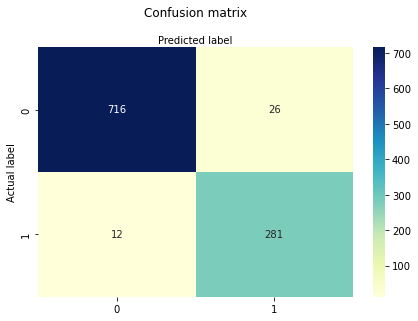

In [90]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_lbfgs_ngram), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Validación mediante curva AUC // ROC CURVE

In [91]:
prob_lbfgs_ngram = clf_lbfgs_ngram.predict_proba(dtv_test_ngram) # # Probabilidad de cada clase (probabilidad de spam y no spam)
# Seleccionamos unicamente la columna que indica que es spam, que serán los 1
prob_lbfgs_ngram = prob_lbfgs_ngram[:,1]

0.9874911455985574


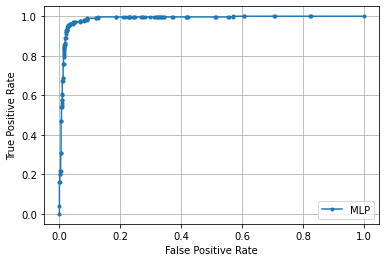

In [92]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc_lbfgs_ngram = roc_auc_score(y_test, prob_lbfgs_ngram)
print(auc_lbfgs_ngram)

fpr, tpr, thresholds = roc_curve(y_test, prob_lbfgs_ngram)

plt.plot(fpr, tpr, marker='.', label='MLP')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [93]:
# Importancia de las Feature para la predicción de Spam
bound_min_importance_word = len(vectorizer_ngram.get_feature_names_out())-15
bound_max_importance_word = len(vectorizer_ngram.get_feature_names_out())
len(vectorizer_ngram.get_feature_names_out())

480

<AxesSubplot:ylabel='Feature'>

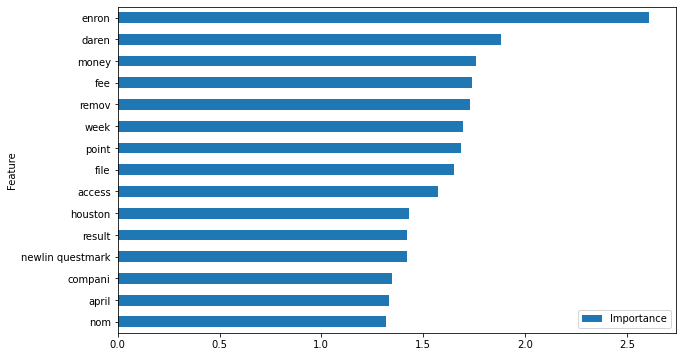

In [94]:
# Cálculo de coeficientes
coefficients_lbfgs_ngram = clf_lbfgs_ngram.coef_

avg_importance_lbfgs_ngram = np.mean(np.abs(coefficients_lbfgs_ngram), axis=0)
feature_importance_lbfgs_ngram = pd.DataFrame({'Feature': vectorizer_ngram.get_feature_names_out(), 'Importance': avg_importance_lbfgs_ngram})
feature_importance_lbfgs_ngram = feature_importance_lbfgs_ngram.sort_values('Importance', ascending=True)
feature_importance_lbfgs_ngram[bound_min_importance_word:bound_max_importance_word].plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [95]:
# Mostramos una matriz en la cual se puede observar la 'importancia' que se le ha dado a cada palabra en el proceso de predicción
pd.set_option('display.max_rows', bound_max_importance_word)
feature_importance_lbfgs_ngram

,Feature,Importance
50,clyne corp,0.000037
128,farmer hou,0.000088
15,america corp,0.000095
116,enron north,0.003232
49,clyne,0.004359
31,base,0.005498
418,subject number,0.008040
87,decemb,0.008347
47,chokshi corp,0.008601
438,thank newlin,0.009756
